This script is for validating shifted altimetry data against ground truth LiDAR. It loads a ATL dataframe and underlying LiDAR file and compares the Z values along the ATL track, producing a "z_compare.csv" file.

In [4]:
from cmath import isnan
from ctypes import ArgumentError
from re import I
from statistics import mean
import pandas as pd
import datetime
import os
import argparse
import io
from csv import writer as csvWriter
import math
import numpy as np
from numpy import power as nppower
import datetime
from scipy import stats
import multiprocessing
import traceback

ATL07_SPOT_SIZE = 6

def meanChiropteraForATL(chiropteraDataFrame, atlX, atlY, spotSize):
    """
    Determines the elevation to be used as the corresponding "chiroptera elevation" for the given ATLAS sensor point.
    This works by first querying the dataframe for any points falling within the spot size radius of the given X and Y, which theoretically represent the center of the area illuminated by the ATLAS sensor's laser.
    """

    relevantPoints = chiropteraDataFrame.query("sqrt(@nppower((`x` - @atlX), 2) + @nppower((`y` - @atlY), 2)) <= @spotSize")
    maxZ = relevantPoints["z"].mean()

    return maxZ

def compareToATL07(chiropteraDataFrame, atl07DataFrame):
    """
    Performs the comparison of the given set of chiroptera data to the given set of ATLAS sensor data.
    """

    cMaxX = chiropteraDataFrame["x"].max()
    cMinX = chiropteraDataFrame["x"].min()
    cMaxY = chiropteraDataFrame["y"].max()
    cMinY = chiropteraDataFrame["y"].min()
   
    atl07InBoundsDataFrame = atl07DataFrame[(atl07DataFrame['X'] >= cMinX) & 
                               (atl07DataFrame['X'] <= cMaxX) & 
                               (atl07DataFrame['Y'] >= cMinY) & 
                               (atl07DataFrame['Y'] <= cMaxY)]
    
    #print(f"atl07InBounds has length {len(atl03InBoundsDataFrame)} ")

    chiropteraElevs = []
    atl07Elevs = []

    #this can take a while... calcChiroptera performs a mean over a spot for each corresponding z value in bounds.
    #one approach is to take every Nth Z value...
    for ind, row in atl07InBoundsDataFrame.iterrows():
        x = row["X"]
        y = row["Y"]
        z = row["Z"]
        chiropteraElev = meanChiropteraForATL(chiropteraDataFrame, x, y, ATL07_SPOT_SIZE)
       # print(f"chiropteraElev: {chiropteraElev}")

        if not isnan(chiropteraElev) and not isnan(z):
            chiropteraElevs.append(chiropteraElev)
            atl07Elevs.append(z)

    dfZs = pd.DataFrame(columns=["c","a"])
    dfZs["c"] = chiropteraElevs
    dfZs["a"] = atl07Elevs
    return dfZs

In [3]:
#df should be chirop_names = ["t", "x", "y", "z"]
#df.to_pickle('chiroptera_1b.pkl')

,GPS_time,z,x,y
0,233548.276649,0.305390,569373.46,9492875.38
1,233548.276722,0.545431,569371.30,9492879.73
2,233548.276789,0.745466,569369.48,9492883.67
3,233548.276855,1.065497,569367.84,9492887.60
4,233548.276922,1.225526,569366.30,9492891.52
...,...,...,...,...
399995,233583.460342,-0.011825,570717.69,9497153.29
399996,233583.460409,0.088158,570718.50,9497156.76
399997,233583.460475,0.088139,570719.43,9497160.21
399998,233583.460542,0.128116,570720.53,9497163.60


In [4]:
adf

,X,Y,slope,Z,dt,seg_dist_x,seg_dist,prev_seg_dist,next_seg_dist,conf,stype,ssh_flag,gauss,photon_rate,cloud,mss,ocean,lpe,ib
747,569383.527523,9.492894e+06,3.107485,-0.077074,1.440886e+08,1.049748e+07,8.265216,2.348959,4.132608,0.019092,1,0,0.170,5.750000,2,17.506521,-0.012996,0.057421,-0.062298
746,569386.058394,9.492901e+06,3.102317,-0.118641,1.440886e+08,1.049747e+07,4.697918,3.758668,2.348959,0.027831,1,0,0.105,7.105263,2,17.506575,-0.012995,0.057421,-0.062298
745,569387.499059,9.492906e+06,3.098400,-0.119061,1.440886e+08,1.049747e+07,7.517336,5.380995,3.758668,0.023830,1,0,0.117,6.428571,2,17.506660,-0.012995,0.057421,-0.062299
744,569389.807057,9.492913e+06,3.095595,-0.072071,1.440886e+08,1.049746e+07,10.761990,3.355381,5.380995,0.018244,1,0,0.173,5.259259,2,17.506672,-0.012994,0.057421,-0.062299
743,569393.113902,9.492923e+06,3.091611,-0.047623,1.440886e+08,1.049745e+07,6.710762,3.776221,3.355381,0.012256,1,0,0.248,5.826087,2,17.506744,-0.012993,0.057421,-0.062299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,570796.211653,9.497289e+06,3.117567,0.106735,1.440886e+08,1.049286e+07,8.315591,3.728803,4.157796,0.011286,1,0,0.255,5.040000,2,17.535614,-0.012471,0.057430,-0.062480
3,570798.750519,9.497297e+06,3.115542,0.161404,1.440886e+08,1.049285e+07,7.457607,3.437135,3.728803,0.011042,1,0,0.278,5.727272,2,17.535671,-0.012470,0.057430,-0.062480
2,570801.028706,9.497304e+06,3.116949,0.528564,1.440886e+08,1.049284e+07,6.874270,2.768056,3.437135,0.007803,1,0,0.548,6.190476,2,17.535732,-0.012469,0.057430,-0.062480
1,570803.127928,9.497311e+06,3.118059,0.588644,1.440886e+08,1.049284e+07,5.536112,3.419722,2.768056,0.009623,1,0,0.369,6.500000,2,17.535734,-0.012468,0.057430,-0.062481


In [7]:
for i in range(0,8):
    b1 = i * 4
    b2 = b1 + 4
    adf = pd.read_csv(f'debug_shifted_atl_{b1}_{b2}.csv')
    adf = adf.rename(columns={'x': 'X'})
    adf = adf.rename(columns={'y': 'Y'})
    adf = adf.rename(columns={'heights': 'Z'})
    adf = adf.sort_values(by='X', ascending=True)
    df = pd.read_csv(f'1C_chirop_{b1}_{b2}.csv')
    dfZs = compareToATL07(df, adf)
    y1 = dfZs['c']
    y2 = dfZs['a']
    slope, intercept, r_value, p_value, std_err = stats.linregress(y1, y2)
    print(r_value**2)

0.32985636653050293
0.09746966146907761
0.25674100731736593
0.25049936618009633
0.013481579925890021
0.054839846780438434
0.008984602123006979
0.017365107540527107


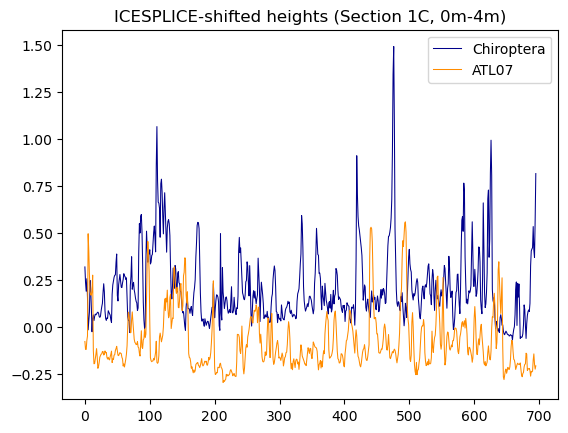

0.00034128410240854434


In [6]:
#Visualize Z-Compare
import pandas as pd
import matplotlib.pyplot as plt

# # Load the CSV file
# file_path = 'z_compare.csv'
# data = pd.read_csv(file_path)

x = dfZs.index
#chirop
y1 = dfZs['c']

#atl
y2 = dfZs['a']

fig,ax = plt.subplots()
# Plot the data
plt.plot(x, y1, label='Chiroptera', color='darkblue',linewidth=0.75)
plt.plot(x, y2, label='ATL07', color='darkorange',linewidth=0.75)
plt.legend()

slope, intercept, r_value, p_value, std_err = stats.linregress(y1, y2)

plt.title('ICESPLICE-shifted heights (Section 1C, 0m-4m)')
#plt.grid(True)
plt.show()
print(r_value**2)